In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nasdaqdatalink
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools


In [2]:
# This loads the variables from .env
load_dotenv()  
# Get your apis or usernames
nsdk_api = os.getenv('api_key_nasdaq')

# Activate the account to download data
nasdaqdatalink.ApiConfig.api_key = nsdk_api

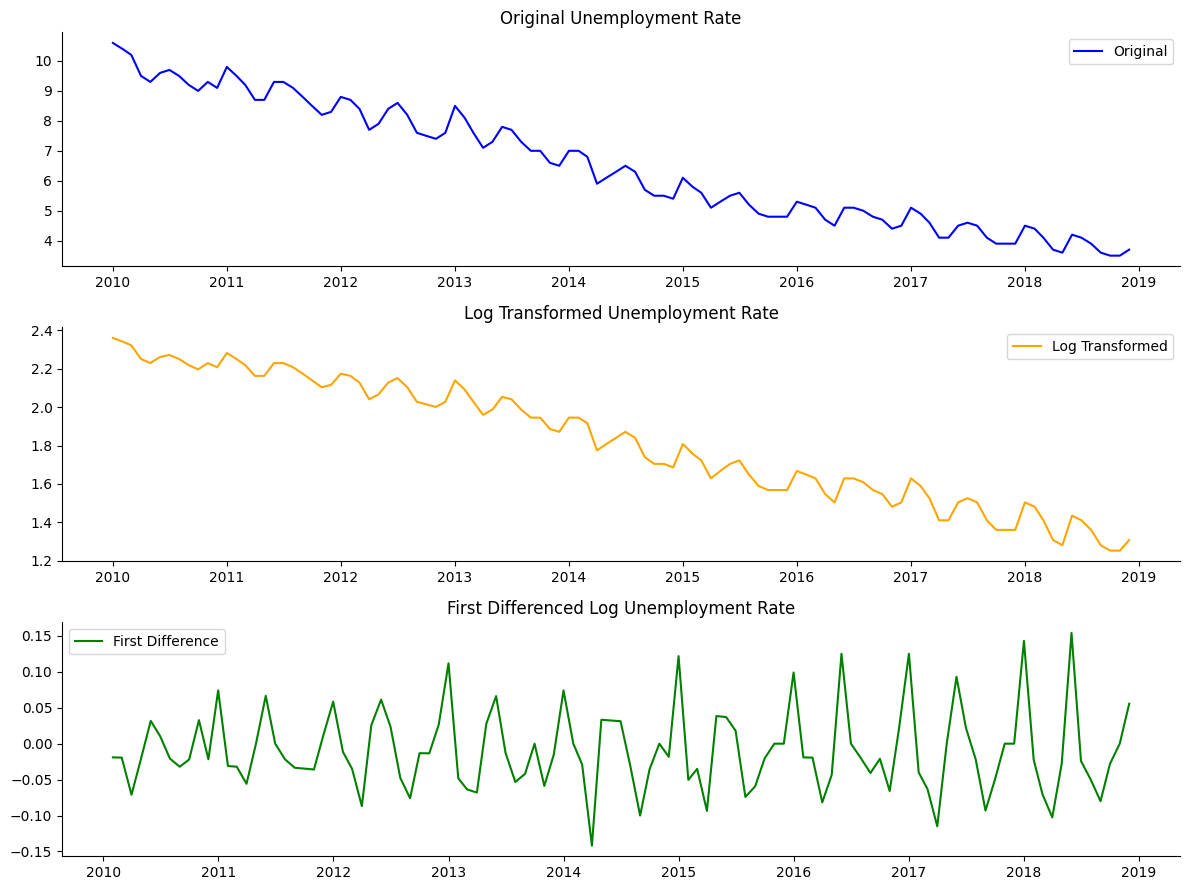

In [3]:
# Retrieve the unemployment rate data from the FRED database
# Using the nasdaqdatalink API
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)

# Set the DataFrame index to monthly start frequency for time series analysis
df.index.freq = "MS"

# Define the length of the test dataset
# The test set will consist of the last 12 months of data for model evaluation
TEST_LENGTH = 12

# Split the data into training and test sets
# Use .copy() to avoid SettingWithCopyWarning
df_train = df.iloc[:-TEST_LENGTH].copy()
df_test = df.iloc[-TEST_LENGTH:].copy()

# Apply transformations to the training data for stationarity
# Log transformation is often used to stabilize the variance
df_train["unemp_rate_log"] = np.log(df_train["unemp_rate"])
df_test["unemp_rate_log"] = np.log(df_test["unemp_rate"])

# First differencing to remove trend
df_train["first_diff"] = df_train["unemp_rate_log"].diff()
df_test["first_diff"] = df_test["unemp_rate_log"].diff()

# Plotting the original series, log-transformed series, and first differenced series
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), dpi=100)
axes[0].plot(df_train.index, df_train["unemp_rate"], color='blue', label='Original')
axes[0].set_title('Original Unemployment Rate')
axes[0].legend()

axes[1].plot(df_train.index, df_train["unemp_rate_log"], color='orange', label='Log Transformed')
axes[1].set_title('Log Transformed Unemployment Rate')
axes[1].legend()

axes[2].plot(df_train.index, df_train["first_diff"], color='green', label='First Difference')
axes[2].set_title('First Differenced Log Unemployment Rate')
axes[2].legend()

# Improve aesthetics
sns.despine()
plt.tight_layout()
plt.show()


/var/folders/7q/gtgwb0b50lb9drgtm4rch91m0000gp/T/ipykernel_85556/3081094757.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_train['first_diff'], regression='c')


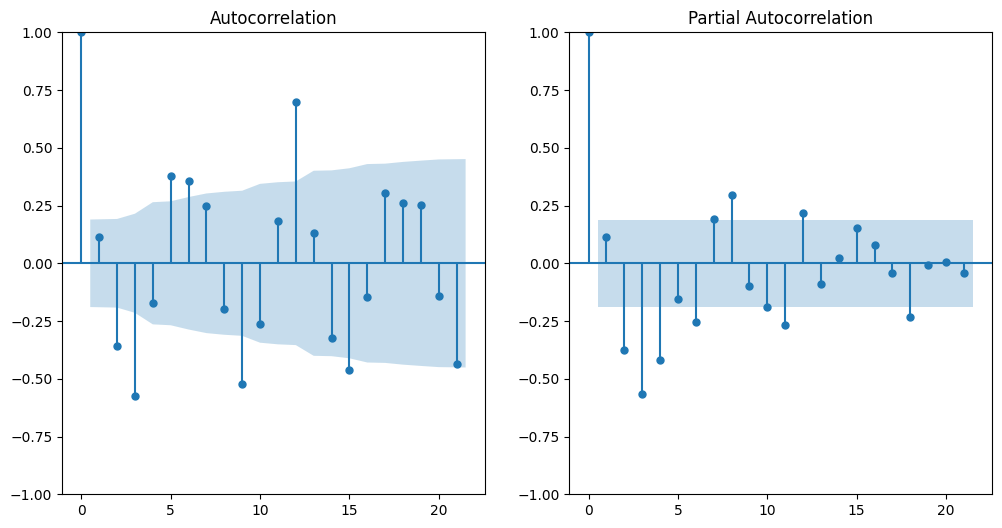

In [5]:
# Handling missing values by dropping them
df_train = df_train.dropna(subset=['first_diff'])


# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df_train['first_diff'])
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

# Perform KPSS test
kpss_result = kpss(df_train['first_diff'], regression='c')
kpss_statistic = kpss_result[0]
kpss_p_value = kpss_result[1]



# print(latex_table)

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df_train['first_diff'], ax=ax1)
plot_pacf(df_train['first_diff'], ax=ax2)
plt.show()

In [6]:
# Create a LaTeX table with a note for the KPSS test warning
latex_table = r"""
\documentclass{{article}}
\usepackage{{amsmath}}
\usepackage{{float}} 
\pagestyle{{empty}}
\begin{{document}}
\begin{{table}}[H]
\centering
\begin{{tabular}}{{lcc}}
\hline
Test & Statistic & p-value \\ \hline
ADF & ${:.4f}$ & ${:.4f}$ \\
KPSS & ${:.4f}$ & ${:.4f}$ \\ \hline
\end{{tabular}}
\caption{{Stationarity Test Results}}
\label{{tab:stationarity_tests}}
\end{{table}}
\vspace{{1ex}} % Adjust the space as needed
\footnotesize *KPSS p-value is greater than the reported value due to an interpolation warning.
\end{{document}}
""".format(adf_statistic, adf_p_value, kpss_statistic, kpss_p_value)

print(latex_table)



\documentclass{article}
\usepackage{amsmath}
\usepackage{float} 
\pagestyle{empty}
\begin{document}
\begin{table}[H]
\centering
\begin{tabular}{lcc}
\hline
Test & Statistic & p-value \\ \hline
ADF & $-2.9688$ & $0.0379$ \\
KPSS & $0.0414$ & $0.1000$ \\ \hline
\end{tabular}
\caption{Stationarity Test Results}
\label{tab:stationarity_tests}
\end{table}
\vspace{1ex} % Adjust the space as needed
\footnotesize *KPSS p-value is greater than the reported value due to an interpolation warning.
\end{document}



In [7]:
# Create a set of p, q, given d=1 as we observe that taking difference make series stationary!

max_pq = 3
p = q = range(0, max_pq + 1)
d=1 
pdq = list(itertools.product(p, [d], q))
# pdq

# Notes on the code below:
This code conducts a brute force search over the specified range of values for p and q, fitting an ARIMA model for each combination and keeping track of the one with the lowest AIC. It assumes you have already determined the appropriate level of differencing d, which I set equal to one as discussed above. Remember to handle exceptions as some combinations of parameters may not converge to a solution.

Keep in mind that this process can be computationally intensive, especially for larger datasets or wider ranges of p and q. Therefore, it's often practical to limit the range of values based on preliminary analysis such as the ACF and PACF plots.

In [8]:

best_aic = float("inf")
best_bic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(df_train['unemp_rate_log'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_bic = results.bic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

print(f"Best ARIMA Model: ARIMA{best_pdq} with AIC: {best_aic} and BIC: {best_bic}")
# You can then look at best_model.summary() for more details or perform residual checks.


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio

Best ARIMA Model: ARIMA(2, 1, 2) with AIC: -381.1816673671896 and BIC: -367.8644718966293


### What are the warnings telling us:

The warning and convergence messages we are seeing are indicative of problems encountered during the fitting of various ARIMA models to our dataset. 

1. **Non-invertible Starting MA Parameters**:
   The warning `Non-invertible starting MA parameters found` means that the initial parameter estimates for the MA part of the model are outside the region where the model is mathematically valid (i.e., the parameters do not correspond to an invertible process). The statsmodels library then defaults to starting with zeros for these parameters.

   To illustrate this further:

   For an MA(q) model, the model is expressed as:

   $$Y_t = \mu + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + ... + \theta_q\varepsilon_{t-q}$$

   Where $\varepsilon_t$ are error terms and $\theta_1, \theta_2, ..., \theta_q$ are parameters of the model.

   **Invertibility** refers to a property of MA models where the model can be rewritten in an equivalent AR(∞) form. For the MA model to be invertible, the roots of the characteristic equation associated with the MA polynomial:

   $$1 + \theta_1z + \theta_2z^2 - ... + \theta_qz^q = 0$$

   must lie outside the unit circle in the complex plane (i.e., they must have a modulus greater than one). If an estimated MA parameter leads to a root inside the unit circle, the model is not invertible, and the warning is issued. 

   When this warning occurs, `statsmodels` attempts to re-estimate the model starting from zero values for the MA parameters.

   Note: You can read more about this [lecture](http://www-stat.wharton.upenn.edu/~stine/stat910/lectures/08_intro_arma.pdf) under the title "Invertibility of ARMA processes". 

2. **Non-stationary Starting AR Parameters**:
   The warning `Non-stationary starting autoregressive parameters found` is similar but for the AR part of the model. The initial estimates suggest a non-stationary process, which is not appropriate for an ARIMA model. Therefore, the library resets them to zero.

   For an AR(p) model, the model is expressed as:

    $$Y_t = \phi_1Y_{t-1} + \phi_2Y_{t-2} + ... + \phi_pY_{t-p} + \varepsilon_t$$

    Where $\phi_1, \phi_2, ..., \phi_p$ are the parameters of the model.

    **Stationarity** in this context means that the roots of the characteristic equation associated with the AR polynomial:

    $$1 - \phi_1z - \phi_2z^2 - ... - \phi_pz^p = 0$$

    must lie outside the unit circle. If an estimated AR parameter suggests a root inside the unit circle, the process would be non-stationary, hence the warning.

3. **Convergence Issues**:
   The `ConvergenceWarning: Maximum Likelihood optimization failed to converge` indicates that the optimization algorithm did not converge to a solution within the maximum number of iterations allowed or another convergence criterion was not met. This could mean that the model is not well-specified or that the optimization algorithm needs to be adjusted (e.g., by changing the algorithm, increasing the number of iterations, or adjusting the tolerance).


### Example for ARIMA(2,1,2)

Given the best model ARIMA(2,1,2), the mathematical representation would be:

$$(1 - \phi_1B - \phi_2B^2)(1 - B)Y_t = (1 + \theta_1B + \theta_2B^2)\varepsilon_t$$

Where:
- $B$ is the backshift operator, $BY_t = Y_{t-1}$.
- $\phi_1, \phi_2$ are the AR coefficients.
- $\theta_1, \theta_2$ are the MA coefficients.
- $\varepsilon_t$ is the white noise error term.

Here, the process is differenced once (the term $(1 - B)$) to achieve stationarity, and then an ARMA(2,2) model is fitted to the differenced series. The non-invertibility and non-stationarity warnings suggest that the initial guesses for $\phi$ and $\theta$ led to models violating the stationarity/invertibility conditions. The optimization warning suggests the final estimates may not be the best possible values due to convergence issues.

### Practical Implications

When you receive these warnings during grid search, the implications are:

1. **Inference**: The parameter estimates from the model may not be reliable. It's important to check the model diagnostics to ensure that the residuals are white noise and that the parameter values make sense.

2. **Model Selection**: Even if a model has a low AIC/BIC, you should be cautious about selecting it if there are convergence issues or non-invertibility. It might be that a model with slightly higher AIC/BIC but without these issues is a better choice.

3. **Further Optimization**: You might need to try different optimization techniques, such as providing different starting values, increasing the number of iterations, or changing the optimization algorithm.
   

### Some comments about likelihood AIC and BIC:
When referring to AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion), saying "lower values are preferred" does indeed mean more negative in the context of these criteria. This is because both AIC and BIC are relative measures of model quality and complexity; they penalize the likelihood of a model based on the number of parameters, striving for the model that best balances fit and simplicity.

The AIC is calculated as:
$$\text{AIC} = 2k - 2\ln(L)$$

And the BIC is:
$$\text{BIC} = \ln(n)k - 2\ln(L)$$

Where:
- $k$ is the number of estimated parameters in the model.
- $L$ is the maximized value of the likelihood function for the model.
- $n$ is the number of observations.

Both criteria are structured such that they will be lower (more negative) for a model that fits the data well (resulting in a higher likelihood $L$ and thus a lower \(-2\ln(L)\)) while having fewer parameters (resulting in a lower $2k$ or $\ln(n)k$).

When comparing models using these criteria, we're looking for the model that has the smallest (most negative) AIC or BIC value because it suggests the model is providing the best fit with the fewest parameters necessary to achieve that fit.

In the output from our code, the ARIMA(2, 1, 2) model has the lowest AIC and BIC of all the models that were evaluated, making it the preferred model according to these criteria, despite the convergence issues and warnings that were also reported. However, due to the warnings about convergence, one should approach this result with caution, ensuring to perform diagnostic checks on the residuals and potentially considering simpler models to see if they perform adequately without the convergence issues.

In [42]:
# Fit an ARIMA(2,1,2) model into our dataset
model = ARIMA(df_train['unemp_rate_log'], order=(2, 1, 2), trend='n') # setting the trend parameter to 'n' for no constant or to 't' for including a trend,  or 'c' to include a constant
model_fit = model.fit()


# Output the summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         unemp_rate_log   No. Observations:                  107
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 195.591
Date:                Thu, 14 Dec 2023   AIC                           -381.182
Time:                        14:17:53   BIC                           -367.864
Sample:                    02-01-2010   HQIC                          -375.784
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9830      0.028     35.297      0.000       0.928       1.038
ar.L2         -0.9603      0.026    -37.009      0.000      -1.011      -0.909
ma.L1         -1.2382      0.040    -30.970      0.0

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Based on the summary table you've provided for an ARIMA(2,1,2) model, here's what can be extracted:

1. **Model Information**:
   - The dependent variable is `unemp_rate_log`, which is the logarithm of the unemployment rate, suggesting that log transformation has been applied to the original data for stabilization of variance or to achieve linearity.
   - The model used is an ARIMA(2,1,2), indicating 2 autoregressive terms, 1 level of differencing, and 2 moving average terms.
   - There are 107 observations used in fitting the model.

2. **Fit Quality**:
   - The `Log Likelihood` value is relatively high at 195.591, indicating the model fits the data well.
   - The `AIC`, `BIC`, and `HQIC` are all negative, which is typical for time series models. The lower (or more negative) these values, the better the model balances fit and complexity.

3. **Parameter Estimates**:
   - The coefficients for both AR terms (ar.L1 and ar.L2) and MA terms (ma.L1 and ma.L2) are significant, as indicated by the P>|z| values being 0.000 (less than any conventional alpha level, such as 0.05 or 0.01).
   - The AR coefficients are close to 1 in absolute value, which might indicate a near unit root behavior or over-differencing. However, since we're looking at an ARIMA model, the differencing has been accounted for.

4. **Diagnostic Tests**:
   - The `Ljung-Box (Q)` statistic is 6.78 with a `Prob(Q)` of 0.01. This tests the null hypothesis that residuals are independently distributed (no autocorrelation). A p-value below 0.05 typically rejects the null, suggesting there may be autocorrelation at lag 1.
   - The `Jarque-Bera (JB)` statistic tests whether the residuals have the skewness and kurtosis matching a normal distribution. With a `Prob(JB)` of 0.18, the test does not reject the null hypothesis of normality at conventional significance levels.
   - `Heteroskedasticity (H)` is 1.82 with a `Prob(H)` (two-sided) of 0.08. This tests the null hypothesis of homoscedastic residuals (constant variance). The p-value suggests that there is no strong evidence against constant variance, although it is close to the conventional 0.05 threshold.

5. **Covariance Type**:
   - `opg` stands for the outer product of gradients, which indicates the method used to estimate the variance-covariance matrix of the coefficients. You can read more about variance-covarience matrix from many textbook, but I advice you not to at this stage and time. If you are interested drop me an email! 

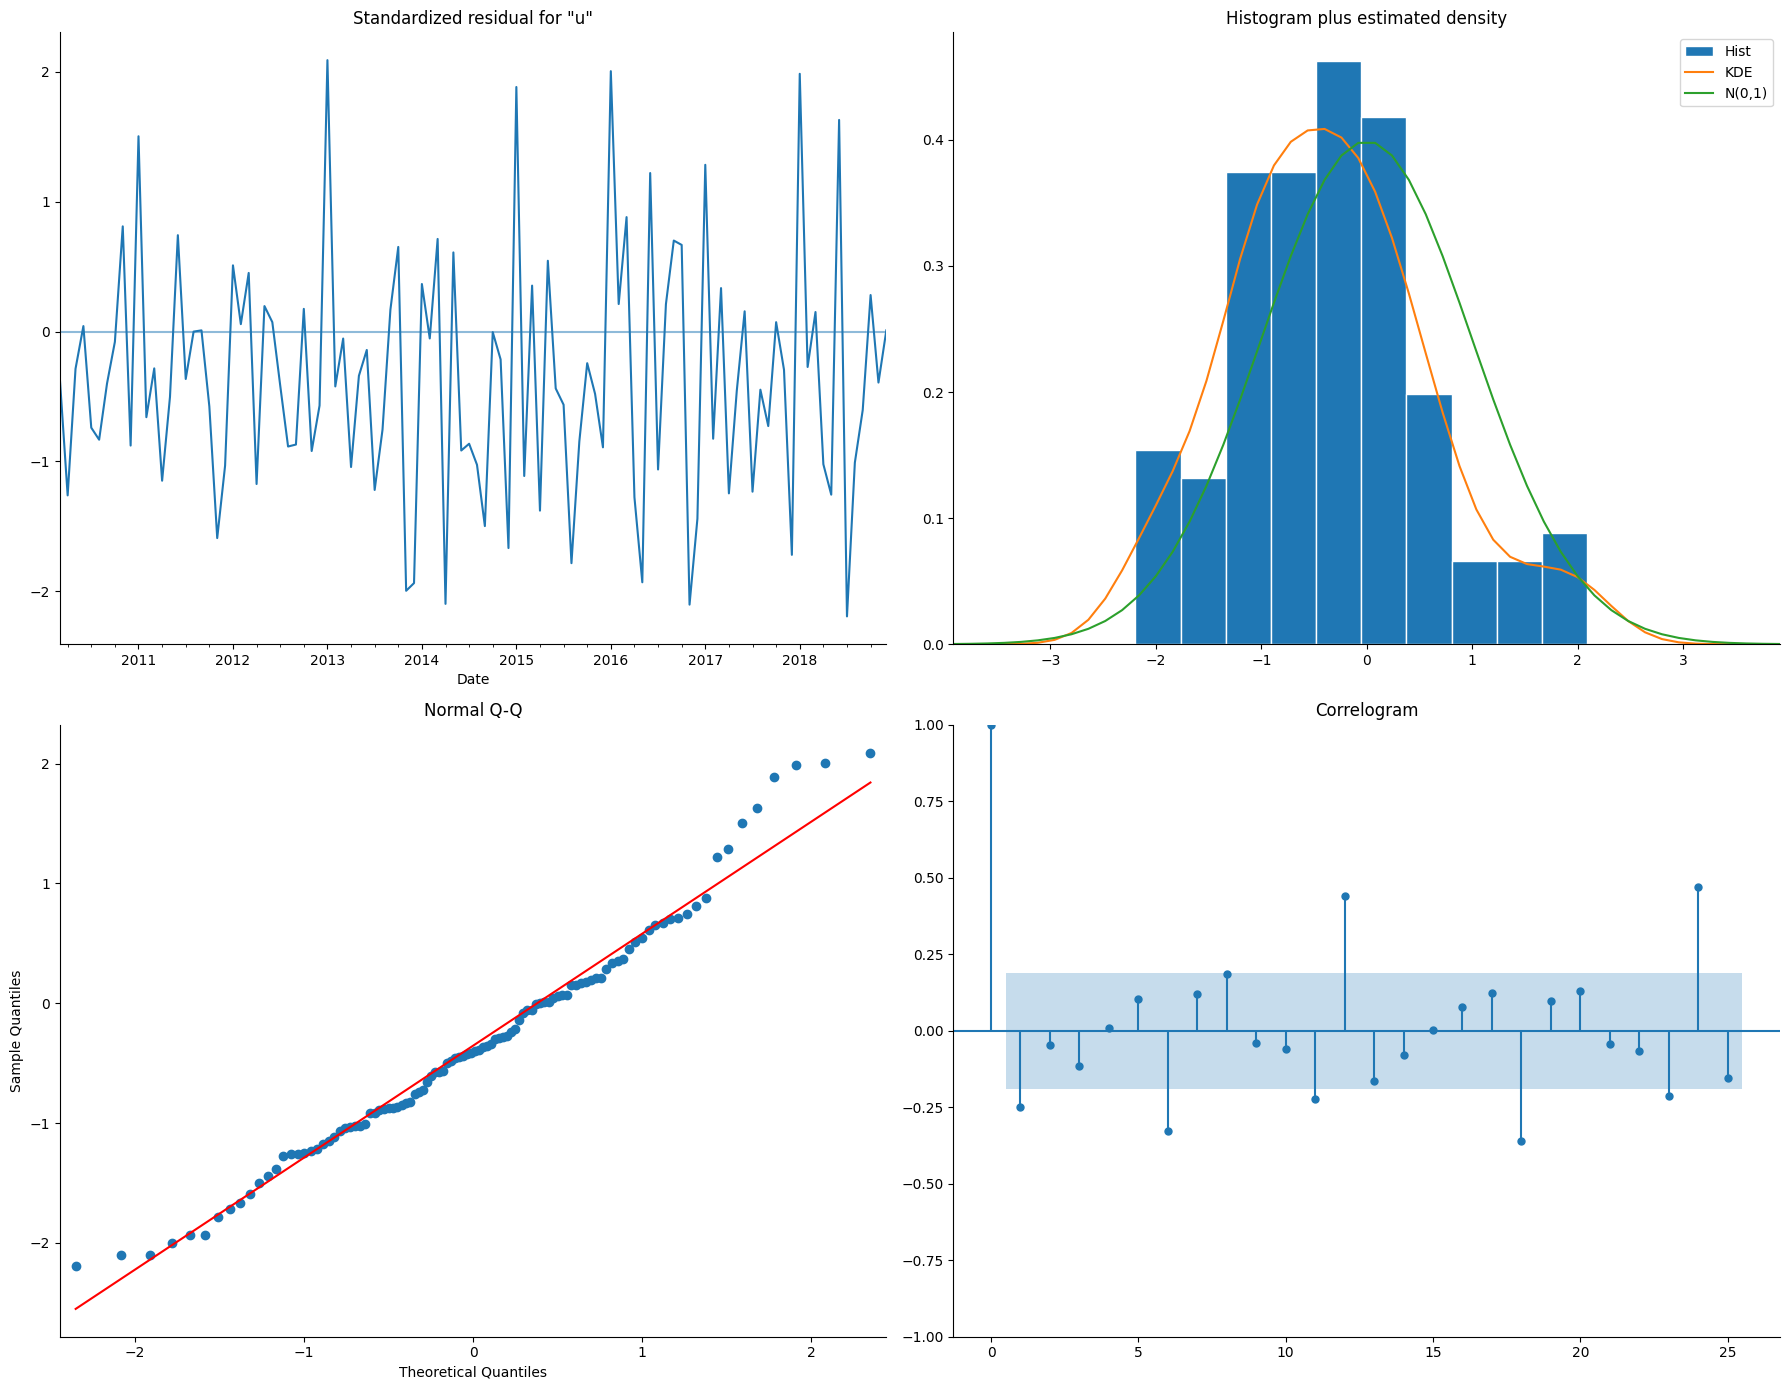

In [43]:
# Let us do some diagnostic check on the residuals
# Conduct diagnostic checks on the residuals
residuals = model_fit.resid
model_fit.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()

The diagnostic checks for an ARIMA model typically include examining the residuals to ensure that they resemble white noise. The `plot_diagnostics` output we've provided gives us four different plots that are commonly used for this purpose. Let's go through each plot and its implications:

1. **Standardized Residuals Plot**:
   - This plot shows the time series of standardized residuals. Ideally, we want to see no obvious patterns or trends; the residuals should fluctuate around zero.
   - If there are patterns or the mean is significantly different from zero, this might indicate that the model has not fully captured the data's structure.

2. **Histogram Plus Estimated Density Plot**:
   - The histogram shows the distribution of the residuals, overlaid with a kernel density estimate (KDE) and the normal distribution for comparison.
   - Ideally, the residuals should follow a normal distribution, indicated by the KDE closely matching the normal distribution curve (green line). The Jarque-Bera test (from the previous table) also assesses normality, with a higher p-value indicating that the data is more likely to be normally distributed.
   - In our case, the residuals seem to be fairly normally distributed, although there's a slight skew.

3. **Normal Q-Q Plot**:
   - The Q-Q plot compares the quantiles of the residuals with the quantiles of a normal distribution. If the residuals are normally distributed, the points should lie approximately along the red line.
   - Points deviating from the line can indicate departures from normality. Our Q-Q plot indicates that the residuals are mostly normally distributed, with only minor deviations.

4. **Correlogram (ACF Plot)**:
   - The correlogram shows the autocorrelations of the residuals up to lag 25. Ideally, all autocorrelations should be within the blue band, which represents the confidence intervals. This would suggest that there is no autocorrelation in the residuals.
   - In our case, most of the autocorrelations are within the band, with perhaps one or two borderline exceptions.



## How to continue? 

- **Statistical Tests**: Consider conducting additional statistical tests, such as the Durbin-Watson statistic for autocorrelation or the Shapiro-Wilk test for normality.
- **Model Refinement**: If there are indications of remaining patterns or non-randomness in the residuals, we may need to refine our model. This could involve adding seasonal terms if seasonality is suspected, or trying different combinations of p, d, and q.
- **Out-of-Sample Testing**: If possible, evaluate the model's forecasting accuracy using out-of-sample data. This can help confirm that our model will perform well on data it has not been trained on.
- **Model Comparison**: we might also compare our current model's performance with simpler or more complex models, or non-ARIMA models altogether, to ensure that we've chosen the best one.

In [11]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [44]:
# Durbin-Watson statistic for autocorrelation
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# A value close to 2 suggests no autocorrelation, values < 2 suggest positive autocorrelation, and > 2 suggest negative autocorrelation.

# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}')

# A p-value greater than 0.05 suggests that the residuals are normally distributed.

# Out-of-Sample Testing
# Forecasting the next values using the model and comparing with the actual test set
forecast = model_fit.get_forecast(steps=len(df_test))
predicted_values = forecast.predicted_mean
actual_values = df_test['unemp_rate_log']

# Calculate the Mean Squared Error
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mse)
print(f'Out-of-sample RMSE: {rmse}')

Durbin-Watson statistic: 1.0476611617235614
Shapiro-Wilk test statistic: 0.16817182302474976, p-value: 6.923401762614932e-22
Out-of-sample RMSE: 0.06995667142650328


The Shapiro-Wilk test statistic is 0.168 with a p-value effectively at 0 (approximately $6.92 \times 10^{-22}$), which is much less than the conventional alpha level of 0.05. This strongly rejects the null hypothesis of the residuals being normally distributed. The residuals are not normally distributed, which implies that the model might not be correctly specified or that there are non-linear patterns that the model is not capturing.

The RMSE of approximately 0.07 suggests that on average, the model's predictions are about 0.07 units away from the actual logged unemployment rate values in the out-of-sample testing. Whether this is acceptable depends on the context and scale of your data.

## What should we do? 

It truly depends on your aim; if you want to have a model that fits the dataset just fine with some way to make an inference, then what we have acheived is just fine.  Otherwise, you can try to suit different models to see if this can be improved, it really matter of how deep research are you doing and time you have to make a perfect model. However, because real-world data is not synthesised, you should assume that not all of the conditions will be met, and this is still an area of investigation by many researchers nowadays. There are always numerous approaches and ways, and one should always be open to them, based on his or her priorities, whether best forecasting or studying past occurrences. 

Now, one can argue that can continue by Model Refinement as the previous test suggested there's evidence of positive autocorrelation and non-normal residuals. This is obviously one way to go. Another way you can go is to think on what new model that we have not address in our lectures would do the job, maybe something like seasonal ARIMA model (SARIMA) if there is a seasonal pattern! Another way is possibly to address how to make the residuals normal and many researchers say by doing some form of transformation. 

Remember that you set the ultimate goal, usually the goal is to have a good potential model to predict the test values. Therefore, the minor goal would be to find the ideal model (which usually does not exit)  whereby its (i.e. the model) residuals resemble white noise (no autocorrelation, normally distributed). However, if the RMSE is small relative to the variation and scale of the data, the model might still be useful despite the statistical issues indicated by the tests which is the case in our example and therefore, I will suffice myself with this model. However this is open for criticism and further research. 

In [15]:
# Fit an ARIMA(2,1,2) model
model = SARIMAX(df_train['unemp_rate_log'], order=(1, 1, 1), trend='n', enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
residuals = model_fit.resid

# Statistical Tests

# Durbin-Watson statistic for autocorrelation
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# A value close to 2 suggests no autocorrelation, values < 2 suggest positive autocorrelation, and > 2 suggest negative autocorrelation.
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}')

# A p-value greater than 0.05 suggests that the residuals are normally distributed.

# Out-of-Sample Testing
# Forecasting the next values using the model and comparing with the actual test set
forecast = model_fit.get_forecast(steps=len(df_test))
predicted_values = forecast.predicted_mean
actual_values = df_test['unemp_rate_log']

# Calculate the Mean Squared Error
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mse)
print(f'Out-of-sample RMSE: {rmse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38739D+00    |proj g|=  2.25711D+00

At iterate    5    f= -1.39435D+00    |proj g|=  6.21656D-02

At iterate   10    f= -1.41125D+00    |proj g|=  2.70366D+00

At iterate   15    f= -1.42272D+00    |proj g|=  2.06290D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     36      1     0     0   5.359D-05  -1.423D+00
  F =  -1.4227306116131599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Durbin-W

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [21]:
in_sample_prediction_ci

,lower unemp_rate_log,upper unemp_rate_log
Date,,
2010-02-01,-2771.807649,2771.807649
2010-03-01,-2090.775442,2096.703373
2010-04-01,2.176693,2.447447
2010-05-01,2.123315,2.361509
2010-06-01,2.112420,2.340229
...,...,...
2018-08-01,1.296701,1.515787
2018-09-01,1.257731,1.476817
2018-10-01,1.191556,1.410642


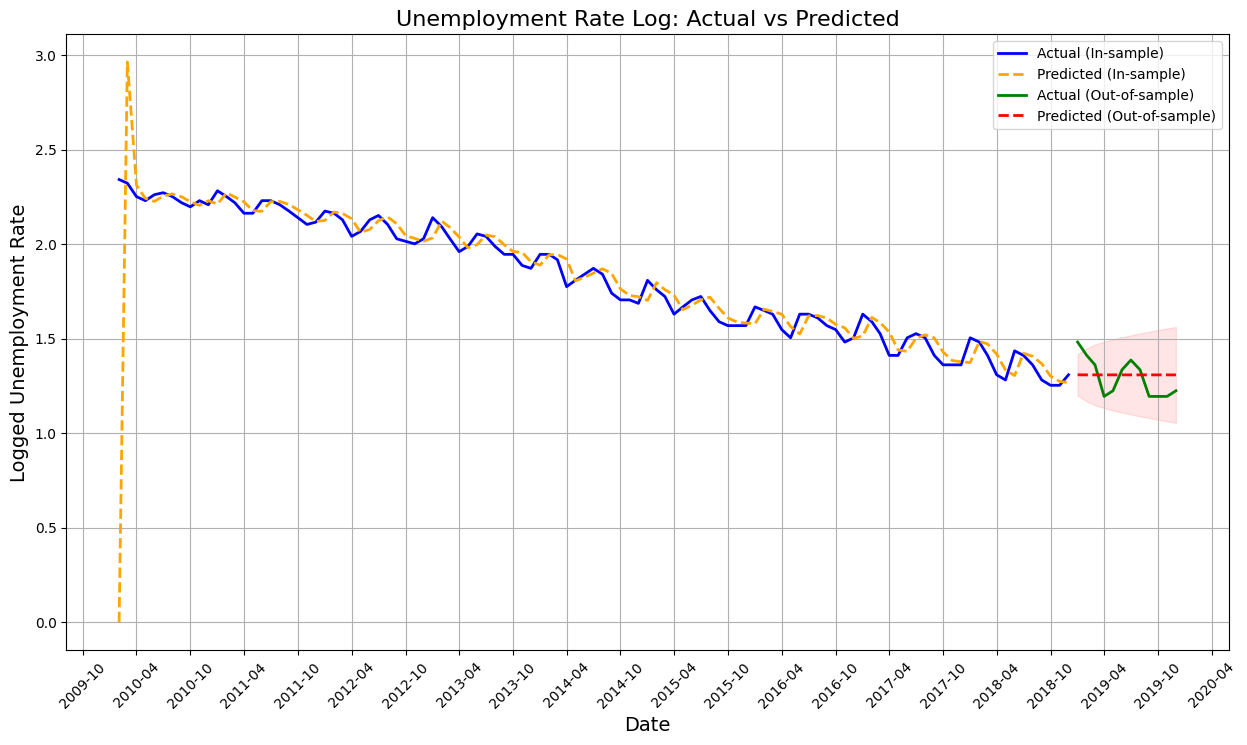

In [23]:
# plot the in-sample and out-of-sample prediction and real data

# In-sample prediction
in_sample_prediction = model_fit.get_prediction(start=df_train.index[0], end=df_train.index[-1])
in_sample_prediction_ci = in_sample_prediction.conf_int()
in_sample_pred = in_sample_prediction.predicted_mean

# Out-of-sample prediction
out_sample_prediction = model_fit.get_forecast(steps=len(df_test))
out_sample_prediction_ci = out_sample_prediction.conf_int()
out_sample_pred = out_sample_prediction.predicted_mean


# Increase the plot size
plt.figure(figsize=(15, 8))

# Plot in-sample actual vs predicted values
plt.plot(df_train.index, df_train['unemp_rate_log'], label='Actual (In-sample)', color='blue', linestyle='-', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='Predicted (In-sample)', color='orange', linestyle='--', linewidth=2)

# Plot out-of-sample actual vs predicted values
plt.plot(df_test.index, df_test['unemp_rate_log'], label='Actual (Out-of-sample)', color='green', linestyle='-', linewidth=2)
plt.plot(out_sample_pred.index, out_sample_pred, label='Predicted (Out-of-sample)', color='red', linestyle='--', linewidth=2)

# Fill the confidence intervals
# plt.fill_between(in_sample_prediction_ci.index, in_sample_prediction_ci.iloc[:, 0], in_sample_prediction_ci.iloc[:, 1], color='orange', alpha=0.1)
plt.fill_between(out_sample_prediction_ci.index, out_sample_prediction_ci.iloc[:, 0], out_sample_prediction_ci.iloc[:, 1], color='red', alpha=0.1)

# Enhance the plot with labels and title
plt.title('Unemployment Rate Log: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Logged Unemployment Rate', fontsize=14)

# Improve the date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



# Finding the best-fitting ARIMA model with auto-ARIMA

* We have discussed about finding the best ARIMA model using likelihood, but we need to talk about them more in available libraries in python.

* We will use the `auto_arima` function from the `pmdarima` package (abbreviated as `pm`) in Python. This function is designed to automate the process of identifying the most optimal parameters for an ARIMA model, which can be a quite tedious and complex process when done manually. 

* The `auto_arima` function then fits a range of ARIMA models with different combinations of parameters (p, d, q) and potentially seasonal parameters (P, D, Q) if `seasonal=True`. It selects the model that best fits the data according to the AIC (Akaike Information Criterion) or another similar criterion.

    ## Comments on SARIMA process:
    The SARIMA $(p, d, q) \times(P, D, Q)_s$ Process of a series $\left\{X_t\right\}$ is defined as a seasonal $\operatorname{ARIMA}(p, d, q) \times$ $(P, D, Q)_s$ process with period $s$ if the differenced process $Y_t:=(1-B)^d$ $\left(1-B^s\right)^D X_t$ is a causal ARMA process, defined as:
    $$
    \phi(B) \Phi\left(B^s\right) Y_t=\theta(B) \Theta\left(B^s\right) Z_t, \quad\left\{Z_t\right\} \sim \mathrm{WN}\left(0, \sigma^2\right),
    $$
    where 
    - $\phi(z) = 1 - \phi_1 z - \cdots - \phi_p z^p$
    - $\Phi(z) = 1 - \Phi_1 z - \cdots - \Phi_P z^P$
    - $\theta(z) = 1 + \theta_1 z + \cdots + \theta_q z^q$
    - $\Theta(z) = 1 + \Theta_1 z + \cdots + \Theta_Q z^Q$


    see [Definition 9.6.1](https://www.google.co.uk/books/edition/Time_Series_Theory_and_Methods/_DcYu_EhVzUC?hl=en&gbpv=1&dq=SARIMA&pg=PA323&printsec=frontcover). 

* Finally, `auto_sarima.summary()` provides a summary of the best model found by `auto_arima`. This summary includes details about the model's coefficients, statistical tests, and diagnostic information, similar to what we get from a manually specified ARIMA model in statsmodels.

**Note**: This approach is particularly useful because it automates the often complex and iterative process of identifying the most appropriate ARIMA model for a given time series dataset along with checking the other components which is very challenging to be done mannually. 



In [31]:
auto_sarima = pm.auto_arima(df_train['unemp_rate_log'], # The time series data we're modeling, specifically the logged unemployment rate.
                            test="adf", # Specifies the type of unit root test to use for determining the order of differencing (d) in the ARIMA model. "adf" refers to the Augmented Dickey-Fuller test. If the ADF test indicates that the series is non-stationary, auto_arima will then difference the series once and test it again for stationarity. This process is repeated as necessary until the test indicates that the differenced series is stationary.
                            seasonal=True, # Indicates that the function should consider seasonal components in the ARIMA model. This is useful if the time series data exhibits seasonality.
                            m=12, # The number of periods in each season. Here, `12` suggests monthly data with annual seasonality.
                            with_intercept=False, # Specifies whether to include an intercept (constant) term in the model. In this case, it's set to `False`, meaning no constant term will be included.
                            stepwise=True, # Enables the stepwise search algorithm for model selection, which is a faster approach than fitting all possible models.
                            suppress_warnings=True,  # Instructs the function to suppress convergence warnings, which can be common during the search process.
                            trace=True) # Outputs detailed information about each step in the model selection process, which can be helpful for understanding how the final model was chosen.
auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-401.785, Time=1.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-363.192, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-394.712, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-399.756, Time=0.24 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-402.923, Time=0.82 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=-401.595, Time=1.74 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-399.619, Time=0.68 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-398.861, Time=2.29 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-399.872, Time=0.55 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(3,1,2)(0,1,1)[12]             : AIC=-406.093, Time=0.91 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=-380.887, Time=0.18 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=-402.223, Time=0.79 sec
 ARIMA(3,1,2)(0,1,2)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  107
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 210.047
Date:                              Wed, 13 Dec 2023   AIC                           -406.093
Time:                                      23:05:41   BIC                           -388.290
Sample:                                  02-01-2010   HQIC                          -398.902
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3721      0.278      1.338      0.181      -0.173       0.917
ar.L2         -0.5183      0.151     -3.434      0.001      -0.814      -0.223
ar.L3         -0.3543      0.150     -2.366      0.018      -0.648      -0.061
ma.L1         -0.7671      0.263     -2.917      0.004      -1.283      -0.252
ma.L2          0.5478      0.194      2.827      0.005       0.168       0.927
ma.S.L12      -0.7512      0.159     -4.715      0.000      -1.063      -0.439
sigma2         0.0006      0.000      5.614      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.99   Prob(JB):                         0.39
Heteroskedasticity (H):               1.43   Skew:                            -0.30
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMA$(3,1,2)\times(0,1,1)_{12}(P, D, Q)_s$ Equation given the fit

To write the equation for a SARIMA $(3,1,2)\times(0,1,1)_{12}$ process, we'll use the given definitions and plug in the specific values for $p, d, q, P, D, Q,$ and $s$. The general form of the SARIMA model is:

$$
\phi(B) \Phi\left(B^s\right) Y_t = \theta(B) \Theta\left(B^s\right) Z_t, \quad \{Z_t\} \sim \mathrm{WN}(0, \sigma^2),
$$

where $Y_t = (1-B)^d (1-B^s)^D X_t$.

Given the SARIMA model parameters $(3,1,2)\times(0,1,1)_{12}$, we have:

- $p = 3$, $d = 1$, $q = 2$
- $P = 0$, $D = 1$, $Q = 1$
- $s = 12$

The polynomials are defined as:

- $\phi(z) = 1 - \phi_1 z - \phi_2 z^2 - \phi_3 z^3$
- $\Phi(z) = 1$ (since $P = 0$, there are no seasonal AR terms)
- $\theta(z) = 1 + \theta_1 z + \theta_2 z^2$
- $\Theta(z) = 1 + \Theta_1 z^{12}$ (since $Q = 1$ and $s = 12$)

Substituting these into the general SARIMA equation, we get:

$$
(1 - \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1 - B)(1 - B^{12}) X_t = (1 + \theta_1 B + \theta_2 B^2)(1 + \Theta_1 B^{12}) Z_t,
$$

where $\{Z_t\} \sim \mathrm{WN}(0, \sigma^2)$.

This equation represents the SARIMA $(3,1,2)\times(0,1,1)_{12}$ process for the time series $\{X_t\}$. The left-hand side of the equation involves the differencing and autoregressive terms, while the right-hand side includes the moving average terms, both non-seasonal and seasonal.

If you expand this, using decent mathematical skills you will reach 
\begin{aligned}
X_{t} =\ &(\phi_1 + 1)X_{t-1} - (\phi_1 - \phi_2) X_{t-2} - (\phi_2 - \phi_3) X_{t-3} - \phi_3 X_{t-4} \\
&+ X_{t-12} - (\phi_1 + 1)X_{t-13} + (\phi_1 - \phi_2) X_{t-14} \\
&+ (\phi_2 - \phi_3) X_{t-15} + \phi_3 X_{t-16} \\
&+ \theta_2 \Theta_1 Z_{t-14} + \theta_1 \Theta_1 Z_{t-13} + \Theta_1 Z_{t-12} \\
&+ \theta_2 Z_{t-2} + \theta_1 Z_{t-1} + Z_t
\end{aligned}

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df_train['unemp_rate_log'] is your time series data
# Fit a SARIMAX(3,1,2)(0,1,1)[12] model
model = SARIMAX(df_train['unemp_rate_log'],
                order=(3, 1, 2),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39332D+00    |proj g|=  1.02471D+01

At iterate    5    f= -1.44305D+00    |proj g|=  7.00731D-01

At iterate   10    f= -1.55524D+00    |proj g|=  2.74817D+01

At iterate   15    f= -1.61815D+00    |proj g|=  1.82679D-01


 This problem is unconstrained.



At iterate   20    f= -1.62311D+00    |proj g|=  2.00719D+00

At iterate   25    f= -1.62448D+00    |proj g|=  5.98882D-02

At iterate   30    f= -1.63562D+00    |proj g|=  6.97125D-01

At iterate   35    f= -1.63679D+00    |proj g|=  5.25486D-01

At iterate   40    f= -1.65281D+00    |proj g|=  6.80441D-01

At iterate   45    f= -1.66227D+00    |proj g|=  5.75879D-01

At iterate   50    f= -1.66290D+00    |proj g|=  1.09961D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.100D-01  -1.663D+00
  F =  -1.6629004649450085     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                       unemp_rate_log   No. Observations:                  107
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 177.930
Date:                              Thu, 14 Dec 2023   AIC                           -341.861
Time:                                      14:07:20   BIC                           -325.275
Sample:                                  02-01-2010   HQIC                          -335.216
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5207      0.235      2.220      0.026       0.061       0.980
ar.L2         -0.55

# Some notes to those who would like to understand further details about the algorithm

- **"This problem is unconstrained."**: This means that the optimization problem does not have any specific constraints on the parameter values. In other words, the values of the parameters are allowed to range freely during the optimization process in search of the best fit.

    Note: Remember when you fit a SARIMAX model, it needs to find the best coefficients that minimize a loss function (usually the sum of the squared errors). This optimization process involves an algorithm to search for the minimum value of the function

- **"RUNNING THE L-BFGS-B CODE"**: L-BFGS-B is the optimization algorithm being used. It's a variation of the [BFGS (Broyden–Fletcher–Goldfarb–Shanno) algorithm](https://www.youtube.com/watch?v=mRo-NUGYZ9w), which is a [quasi-Newton method](https://www.youtube.com/watch?v=VIoWzHlz7k8) for solving unconstrained nonlinear optimization problems. The "L" stands for "Limited memory", which means it's a version that is designed to handle problems with a large number of variables without using too much computer memory. The "B" at the end indicates that the algorithm includes bounds, meaning it can handle cases where you want to set upper or lower limits on the parameter values.

- **"Machine precision"**: This indicates the precision with which the computer can represent numbers. A machine precision of `2.220D-16` is typical for double-precision floating-point arithmetic, which is standard in many computational applications.

- **"N" and "M"**: These are parameters specific to the L-BFGS-B algorithm. "N" is the number of variables in the optimization problem (in our case, 7 parameters are being estimated), and "M" is the number of corrections used in the BFGS update (it's part of the algorithm's internal workings).

- **"At X0 0 variables are exactly at the bounds"**: This means that at the starting point of the optimization (`X0`), none of the parameters are at their limit values. If you had set specific bounds for the parameters, this line would tell you how many of those parameters start at those bounds.

- **"At iterate 0"**: This is the beginning of the optimization process.

- **"f"**: This is the value of the objective function (which the algorithm is trying to minimize) at the current iteration. It usually represents the negative log-likelihood.

- **"|proj g|"**: This is the norm of the projected gradient. It is used as a stopping criterion. If this value is small, it suggests the algorithm is close to a minimum. 


### Note: 
These issues are merely for reference purposes and should not cause you any concern. Messages like these are normal during the optimisation process and usually signal that the algorithm is performing as it should. If the optimisation procedure is successful in determining the best parameters, the output will include a message confirming convergence. If there is a problem, such as a failure to converge or running into bounds that cannot be honoured, a warning or error message will normally be displayed.

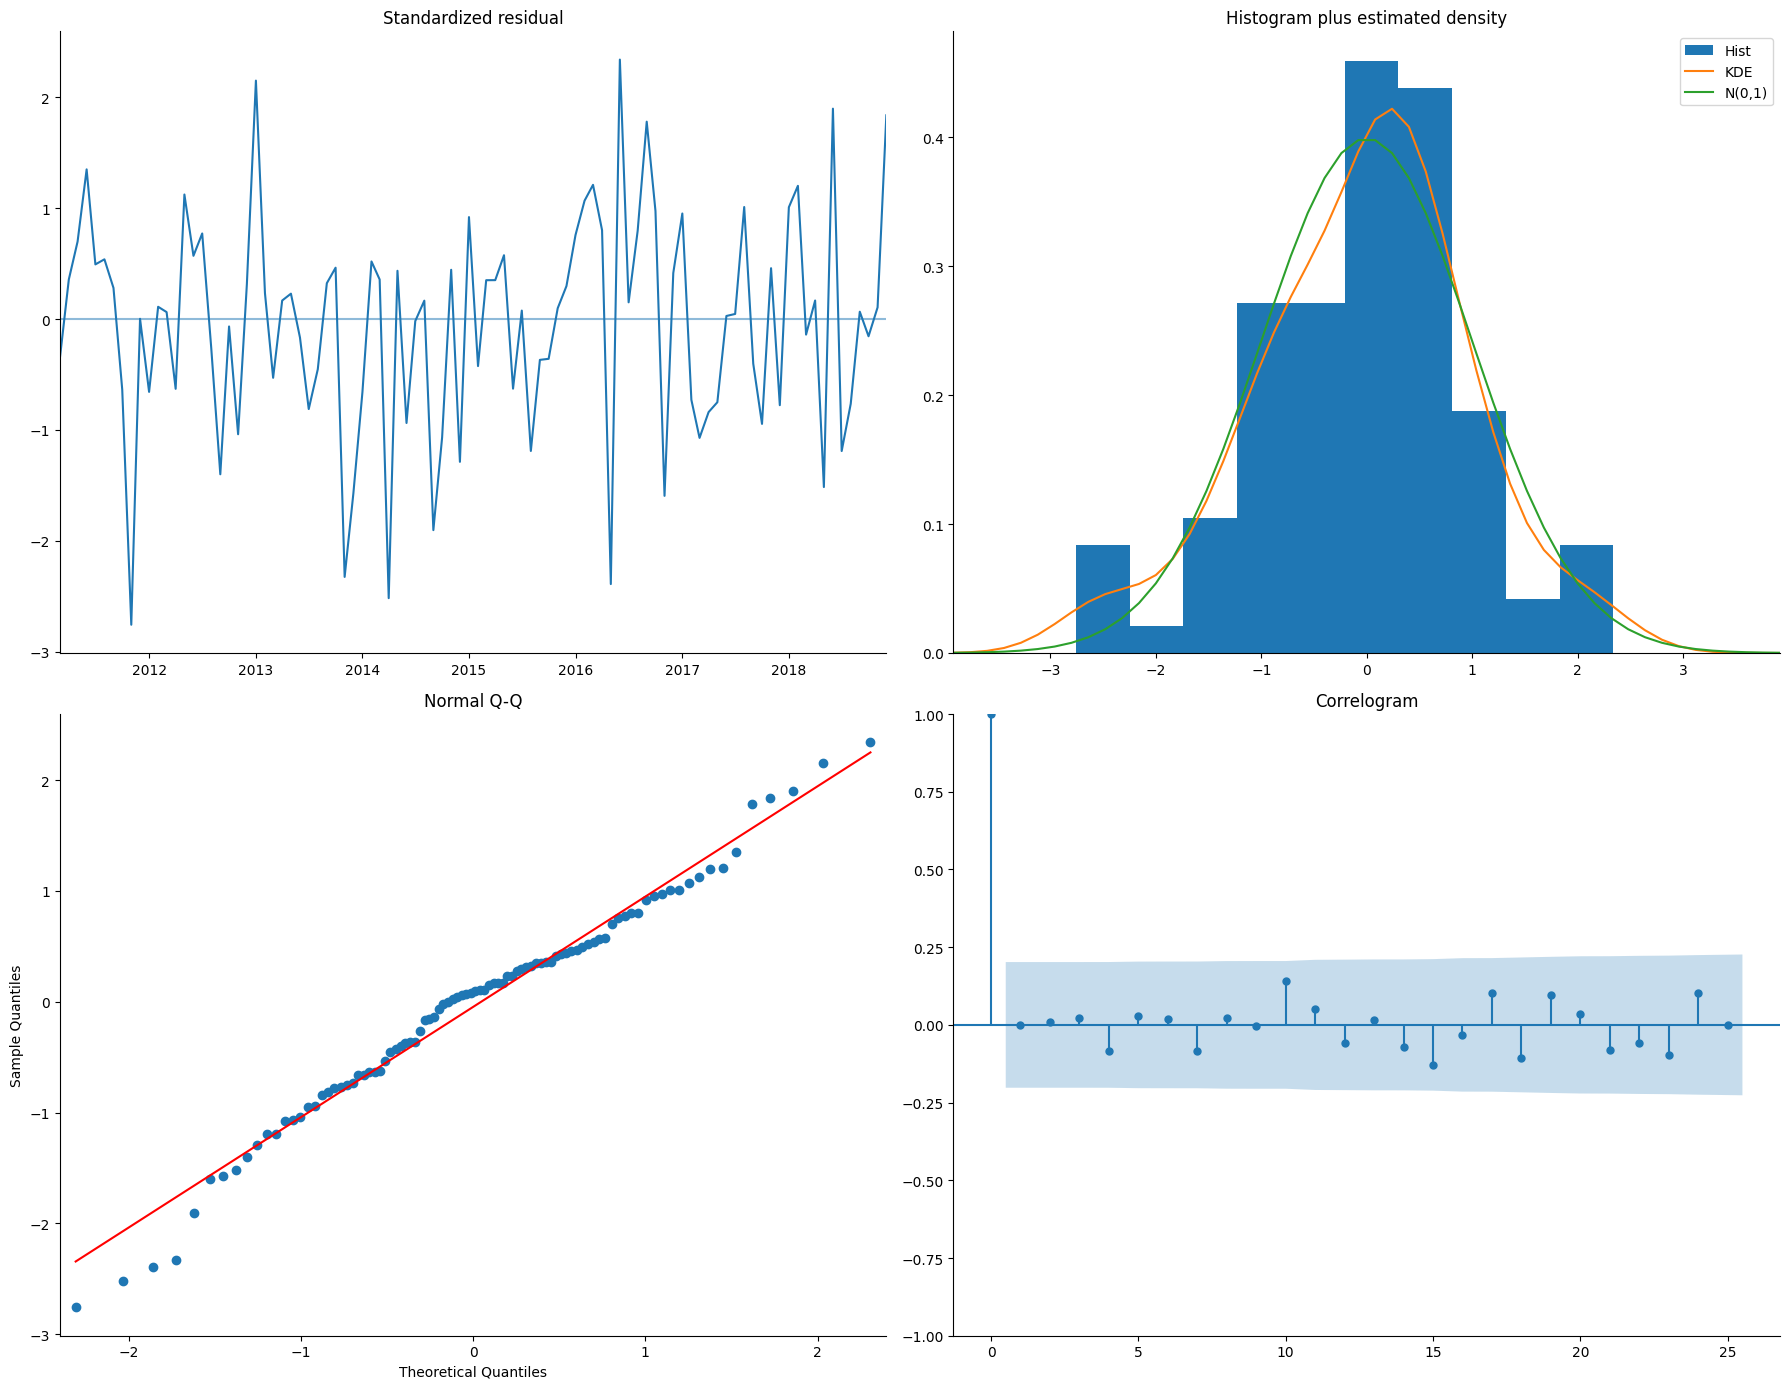

In [32]:
auto_sarima.plot_diagnostics(figsize=(18, 14), lags=25);

sns.despine()
plt.tight_layout()

In [38]:
# Get the residuals
residuals = results.resid

# Statistical Tests

# Durbin-Watson statistic for autocorrelation
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# A value close to 2 suggests no autocorrelation, values < 2 suggest positive autocorrelation, and > 2 suggest negative autocorrelation.
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}')

# A p-value greater than 0.05 suggests that the residuals are normally distributed.

# Out-of-Sample Testing
# Forecasting the next values using the model and comparing with the actual test set
forecast = model_fit.get_forecast(steps=len(df_test))
predicted_values = forecast.predicted_mean
actual_values = df_test['unemp_rate_log']

# Calculate the Mean Squared Error
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mse)
print(f'Out-of-sample RMSE: {rmse}')

Durbin-Watson statistic: 1.8386668356091687
Shapiro-Wilk test statistic: 0.3334565758705139, p-value: 7.149403459887366e-20
Out-of-sample RMSE: 0.09884273538281742


In [ ]:
Durbin-Watson statistic: 1.0476611617235614
Shapiro-Wilk test statistic: 0.16817182302474976, p-value: 6.923401762614932e-22
Out-of-sample RMSE: 0.06995667142650328